In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

In [2]:
path = '../data/BTCdata_2.csv'
df_BTC = pd.read_csv(path, header=0)
df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'Open', 'High', 'Low', 'Close', 'probability of success /Eh', 'expected return (USD/Eh)']]
df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC.head()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
0,450001,1485382343,896.66,896.66,895.43,895.44,0.000593,6.935004,2017-01-25 22:12:23
1,450002,1485383957,895.44,895.86,893.23,894.97,0.000593,7.424957,2017-01-25 22:39:17
2,450003,1485384299,895.44,895.86,893.23,894.97,0.000593,7.184180,2017-01-25 22:44:59
3,450004,1485384419,895.44,895.86,893.23,894.97,0.000593,7.025926,2017-01-25 22:46:59
4,450005,1485384847,895.44,895.86,893.23,894.97,0.000593,7.086069,2017-01-25 22:54:07


* Prices were recorded hourly.
* Simulation starts from the block with height 551443.

In [3]:
df_BTC[df_BTC['height'].isin([551442])]

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
101441,551442,1543137762,3685.01,3700.28,3591.11,3604.59,0.000035,1.577661,2018-11-25 09:22:42


* The unit of `unixtime` is a second.
* Our simulation lasts 84 days, which is equivalent to 84 x 1440 x 60 seconds.

In [4]:
sim_length = 84*1440*60
start_unixtime = 1543137762
df_BTC_sim_period = df_BTC[df_BTC['unixtime']>=start_unixtime]
df_BTC_sim_period = df_BTC_sim_period[df_BTC_sim_period['unixtime']<=start_unixtime + sim_length]
df_BTC_sim_period.head()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
101441,551442,1543137762,3685.01,3700.28,3591.11,3604.59,0.000035,1.577661,2018-11-25 09:22:42
101442,551443,1543137894,3685.01,3700.28,3591.11,3604.59,0.000035,1.584459,2018-11-25 09:24:54
101443,551444,1543138811,3604.59,3677.84,3473.00,3645.60,0.000035,1.631278,2018-11-25 09:40:11
101444,551445,1543138983,3604.59,3677.84,3473.00,3645.60,0.000035,1.602982,2018-11-25 09:43:03
101445,551446,1543139843,3604.59,3677.84,3473.00,3645.60,0.000035,1.627151,2018-11-25 09:57:23


In [5]:
df_BTC_sim_period.tail()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
113414,563415,1550391691,3599.10,3600.47,3598.01,3598.02,0.000038,1.733188,2019-02-17 08:21:31
113415,563416,1550391772,3599.10,3600.47,3598.01,3598.02,0.000038,1.729134,2019-02-17 08:22:52
113416,563417,1550392109,3599.10,3600.47,3598.01,3598.02,0.000038,1.737419,2019-02-17 08:28:29
113417,563418,1550392145,3599.10,3600.47,3598.01,3598.02,0.000038,1.727610,2019-02-17 08:29:05
113418,563419,1550392681,3598.02,3600.30,3597.59,3600.18,0.000038,1.745050,2019-02-17 08:38:01


In [6]:
df_BTC_sim_period.to_csv('../data/BTC_sim_period.csv')

In [7]:
prices_real = df_BTC_sim_period['Close'].values

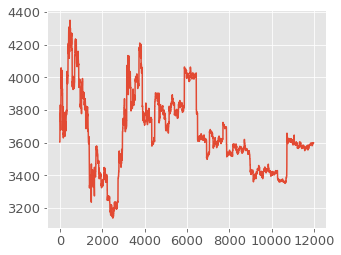

In [8]:
plt.plot(prices_real)
plt.show()

In [9]:
time_real = df_BTC_sim_period['unixtime'].values
time_real = time_real - time_real[0]
time_real = time_real/(1440*60)
time_real

array([ 0.   ,  0.002,  0.012, ..., 83.962, 83.963, 83.969])

In [10]:
winning_rates_real = df_BTC_sim_period['probability of success /Eh'].values

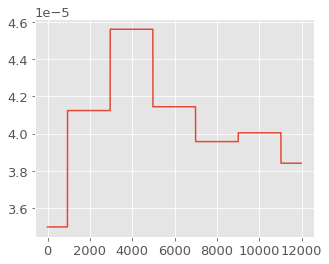

In [11]:
plt.plot(winning_rates_real)
plt.show()

In [12]:
# This path is used in the main text of our paper
df_exprvs = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_exprvs.csv')
df_price = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_prices_ps=0.csv')

In [13]:
no_iter = 3

prices = df_price.loc[:, 'iter_{}'.format(no_iter)]
exprvs = df_exprvs.loc[:,'iter_{}'.format(no_iter)]

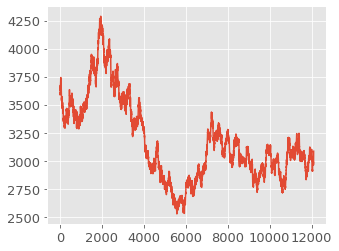

In [14]:
plt.plot(prices[:12096])
plt.show()

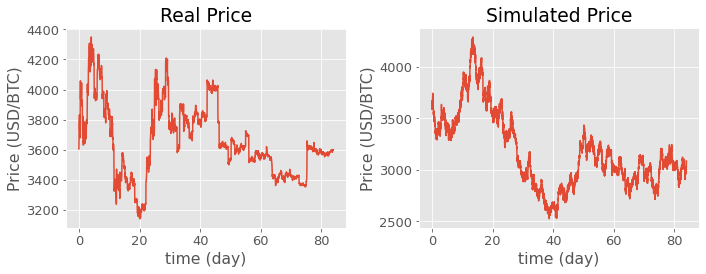

In [15]:
mpl.pyplot.rcParams['figure.figsize'] = (10.0, 4.0)

fig = plt.figure()
time = np.arange(12096)*10/1440
ax1 = fig.add_subplot(1,2,1)
ax1.plot(time_real, prices_real)
ax1.set_xlabel('time (day)')
ax1.set_ylabel('Price (USD/BTC)')
ax1.set_title('Real Price')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(time, prices[:12096])
ax2.set_xlabel('time (day)')
ax2.set_ylabel('Price (USD/BTC)')
ax2.set_title('Simulated Price')

plt.tight_layout()
fig.align_labels()
plt.show()

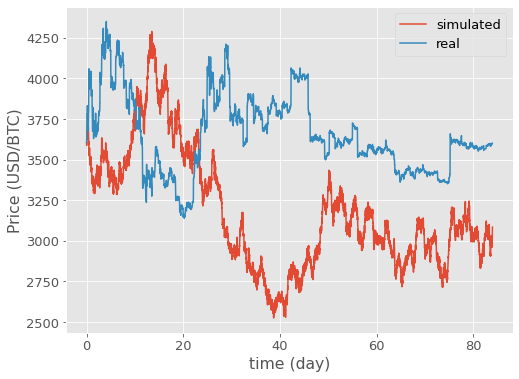

In [16]:
mpl.pyplot.rcParams['figure.figsize'] = (8.0, 6.0)

plt.plot(time, prices[:12096], label='simulated')
plt.plot(time_real, prices_real, label='real')
plt.xlabel('time (day)')
plt.ylabel('Price (USD/BTC)')
plt.legend(loc='best')
plt.show()